[주차 수요 예측 AI 경진대회](https://dacon.io/competitions/official/235745/overview/description)

Baseline을 정리한 코드이다. Colab 환경이다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/연습'

/content/drive/MyDrive/연습


## 패키지

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

## 데이터

In [5]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

In [6]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [7]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [8]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


## 결측치 확인

In [9]:
train.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [10]:
test.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

## 컬럼명 변경

지하쳘역 수와 버스 정류장 수의 컬럼명을 지하철, 버스로 변경하였습니다.

In [11]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [12]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

## 지역명 숫자로 매핑

In [13]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
# local_map은 지역 명과 지역 번호로 매핑

In [18]:
train['지역']

0       0
1       0
2       0
3       0
4       0
       ..
2947    5
2948    5
2949    5
2950    5
2951    5
Name: 지역, Length: 2952, dtype: int64

In [16]:
local_map

{'경상북도': 0,
 '경상남도': 1,
 '대전광역시': 2,
 '경기도': 3,
 '전라북도': 4,
 '강원도': 5,
 '광주광역시': 6,
 '충청남도': 7,
 '부산광역시': 8,
 '제주특별자치도': 9,
 '울산광역시': 10,
 '충청북도': 11,
 '전라남도': 12,
 '대구광역시': 13,
 '서울특별시': 14,
 '세종특별자치시': 15}

In [17]:
train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)
#원래 문자로 되어있던 걸 숫자로 바꿈

## 전용면적을 5의 배수로 변경

In [20]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5
#5로 나눠 몫만 가져옴. 그다음 5를 곱해 소수점이 없음.

## 전용면적 상/하한 적용

상한100, 하한 15

In [24]:
train[train['전용면적']>100].index

Int64Index([], dtype='int64')

In [25]:
train['전용면적']>100

0       False
1       False
2       False
3       False
4       False
        ...  
2947    False
2948    False
2949    False
2950    False
2951    False
Name: 전용면적, Length: 2952, dtype: bool

In [36]:
idx = train[train['전용면적']>100].index

In [37]:
idx

Int64Index([], dtype='int64')

In [43]:
idx = train[train['전용면적']>100].index #train[train['전용면적']] 중에 100을 넘는 값들 index를 가져옴
train.loc[idx, '전용면적'] = 100 #iloc이 아니라 loc을 쓰는 이유는 idx값이 실제 그 index 이름에 들어가야하기 때문임. 결국 전용면적 컬럼에 100을 넘는 값을 전부 100으로 만드는 코드임
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index # 위와 같음. 15보다 작으면 15로 만듦
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15


In [45]:
test['전용면적'].unique() #고유 값을 보여주는데 여기서 15보다 낮거나, 100을 넘는 값은 없다.

array([ 35.,  45.,  50.,  30.,  55.,  25.,  75., 100.,  15.,  20.,  40.,
        60.,  80.,  70.])

## 단지별 데이터 1차원으로 취합

In [46]:
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique(): #여기서도 unique를 써서 고유값이 area 변수에 들어가 area_coulumns 리스트에 "면적_{전용면적 고유값}"이 들어간다.
    area_columns.append(f'면적_{area}')

In [47]:
area_columns 

['면적_35.0',
 '면적_50.0',
 '면적_55.0',
 '면적_30.0',
 '면적_45.0',
 '면적_40.0',
 '면적_25.0',
 '면적_70.0',
 '면적_15.0',
 '면적_20.0',
 '면적_100.0',
 '면적_60.0',
 '면적_75.0',
 '면적_80.0',
 '면적_65.0']

In [48]:
new_train = pd.DataFrame() #pandas는 데이터프레임 변수를 만들어 df를 만든다.
new_test = pd.DataFrame()

In [49]:
train['단지코드']

0       C2483
1       C2483
2       C2483
3       C2483
4       C2483
        ...  
2947    C2532
2948    C2532
2949    C2532
2950    C2532
2951    C2532
Name: 단지코드, Length: 2952, dtype: object

In [54]:
temp.shape

(4, 14)

In [52]:
temp.shape[0]

4

In [64]:
temp.loc[0,'단지코드']

'C2189'

In [66]:
temp[temp['전용면적']==area]['전용면적별세대수']

Series([], Name: 전용면적별세대수, dtype: int64)

In [50]:
for i, code in tqdm(enumerate(train['단지코드'].unique())): #많은 단지 코드 중 고유값만 가져옴. tqdm은 파이썬에서 제공하는 함수로 얼마나 코드가 진행되었는지 보여준다.
    temp = train[train['단지코드']==code] #train에 단지코드중 고유값들을 temp 변수에 넣는다.
    temp.index = range(temp.shape[0]) #temp는 dataframe인데 위에 보면 temp가 4개 행을 가지고 14개 열을 가지기에 shape가 (4,14)이다. #그중 temp 행 길이가 4인데 그 길이만큼 돌게 만드는 temp.index에 range 함수를 넣는다.
    for col in columns: 
        new_train.loc[i, col] = temp.loc[0, col] #temp.loc을 보면 단지코드 C2189 4개 행을 보여준다. 그중 첫행에 columns 변수 '단지코드','총세대수'... 등을 new_train.loc에 i번째 행 col에 넣는다.
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum() #면적과 area변수가 True인 값 중에 전용면적별세대수 값을 new_train 변수에 넣는다..
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수'] #위와 똑같다. 등록차량수는 전부 똑같은 값이다.(왜냐하면 단지 코드가 같으면 등록차량수도 같다..)
    
for i, code in tqdm(enumerate(test['단지코드'].unique())): #아래 코드는 위와 내용이 같다. test용이다.
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:05, 73.67it/s]
150it [00:02, 74.61it/s]


In [ ]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,...,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,...,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
419,C2035,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,...,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
420,C2020,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,...,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
421,C2437,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,16.0


## 결측치 처리

In [70]:
new_train = new_train.fillna(-1)
new_test = new_test.fillna(-1) #na값, nan값을 결측치라 한다. 이 결측치 값을 -1로 채운다.

## 학습

In [71]:
x_train = new_train.iloc[:, 1:-1]  # 등록차량수를 제외한 모든 값.
y_train = new_train.iloc[:,-1] #등록차량수 모든 값
x_test = new_test.iloc[:,1:]

In [75]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,...,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
3,C1945,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
4,C1470,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,C2586,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,...,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
419,C2035,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,...,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
420,C2020,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,...,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
421,C2437,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,16.0


In [74]:
y_train

0      1015.0
1       205.0
2      1064.0
3       730.0
4       553.0
        ...  
418      57.0
419     246.0
420      19.0
421      16.0
422     146.0
Name: 등록차량수, Length: 423, dtype: float64

In [73]:
x_train

,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_35.0,면적_50.0,면적_55.0,면적_30.0,...,면적_40.0,면적_25.0,면적_70.0,면적_15.0,면적_20.0,면적_100.0,면적_60.0,면적_75.0,면적_80.0,면적_65.0
0,900.0,38.0,0.0,1425.0,0.0,3.0,149.0,665.0,86.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,545.0,17.0,1.0,624.0,0.0,3.0,80.0,132.0,0.0,276.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1216.0,13.0,2.0,1285.0,1.0,1.0,0.0,124.0,0.0,390.0,...,362.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,755.0,6.0,3.0,734.0,1.0,3.0,240.0,303.0,212.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,696.0,14.0,4.0,645.0,0.0,2.0,254.0,246.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,90.0,7.0,9.0,66.0,0.0,3.0,36.0,0.0,0.0,0.0,...,0.0,42.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
419,492.0,24.0,5.0,521.0,0.0,1.0,156.0,0.0,0.0,0.0,...,0.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420,40.0,7.0,8.0,25.0,1.0,2.0,15.0,0.0,0.0,0.0,...,0.0,5.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
421,90.0,12.0,11.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0


In [76]:
model = RandomForestRegressor(n_jobs=-1, random_state=42) #모델은 RandomForest이다. 다양한 모델 시도하는 게 좋다. 아래는 랜덤포레스트 파라미터를 정리해놨다. 다양한 파라미터를 조절해 시도하면 좋다.

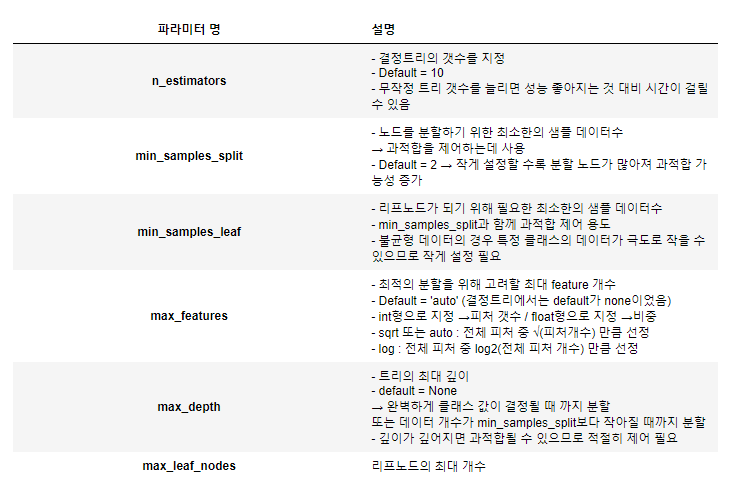

In [77]:
model.fit(x_train, y_train) #시간이 거의 안든다.

RandomForestRegressor(n_jobs=-1, random_state=42)

## 추론 및 제출

In [ ]:
pred = model.predict(x_test) #이제 test, 즉 예측을 한다

In [ ]:
submission['num'] = pred #위에서 가져온 submission csv 파일 num열에 예측값을 넣는다.

In [ ]:
submission.to_csv('baseline.csv', index=False) #dataframe인 submission 변수를 csv로 바꾼다.(이름은 'baseline.csv')